In [21]:
import sys
sys.path.append('..')

In [22]:
from model import ForestFire
from mesa import batch_run
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
import contextlib

## Single Run

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

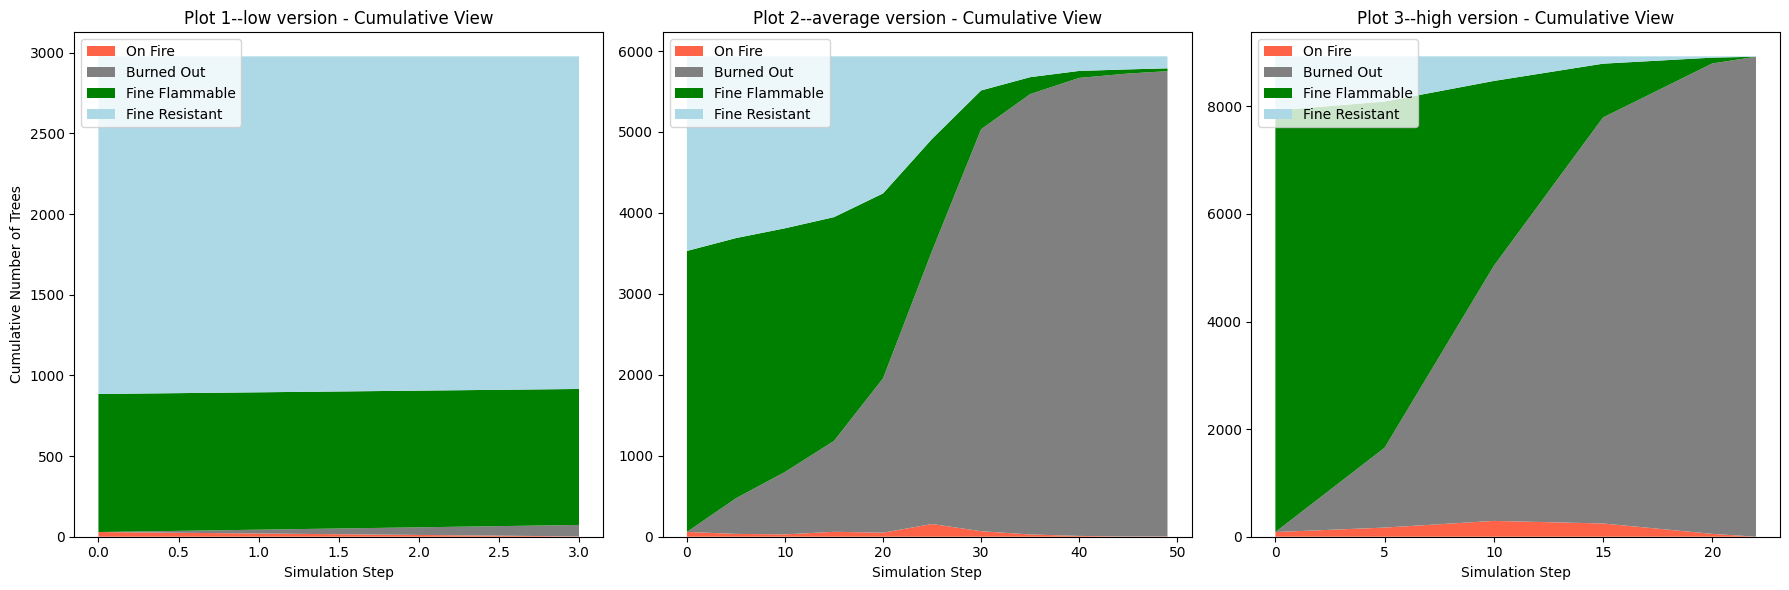

In [33]:

parameter_sets = {
    'Plot 1--low version': {
        "height": 100,
        "width": 100,
        "density": 0.3,
        "Flammable_ratio": 30,
        "wind_chance": 10,
        "wind_radius": 5
    },
    'Plot 2--average version': {
        "height": 100,
        "width": 100,
        "density": 0.6,
        "Flammable_ratio": 60,
        "wind_chance": 30,
        "wind_radius": 10
    },
    'Plot 3--high version': {
        "height": 100,
        "width": 100,
        "density": 0.9,
        "Flammable_ratio": 90,
        "wind_chance": 70,
        "wind_radius": 20
    }
}

def run_and_plot_simulation():
    # Setup for subplots: 1 row, 3 columns
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))  

    for idx, (scenario, params) in enumerate(parameter_sets.items()):
        results = batch_run(ForestFire, 
                            parameters=params,
                            iterations=1,  
                            data_collection_period=5)
        df = pd.DataFrame(results)
        
        # Plot each scenario in its respective subplot
        axes[idx].stackplot(df['Step'], 
                            df['On Fire'], df['Burned Out'], df['Fine Flammable'], df['Fine Resistant'], 
                            labels=['On Fire', 'Burned Out', 'Fine Flammable', 'Fine Resistant'], 
                            colors=['#ff6347', '#808080', '#008000', '#add8e6'])  
        axes[idx].set_title(f'{scenario} - Cumulative View')
        axes[idx].set_xlabel('Simulation Step')
        if idx == 0:  # Only set the ylabel on the first subplot to avoid repetition
            axes[idx].set_ylabel('Cumulative Number of Trees')
        axes[idx].legend(loc='upper left')

    plt.tight_layout()  
    plt.show()

run_and_plot_simulation()


## Batch Run

In [ ]:
# # Get the number of CPUs available
# num_cores = os.cpu_count()
# print(num_cores)

# parameters = {
#     "height": 100,
#     "width": 100,
#     "density": np.linspace(0.01, 1, 4),  
#     "Flammable_ratio": np.linspace(0, 100, 5),
#     "wind_chance": np.linspace(0, 100, 5),  
#     "wind_radius": np.linspace(1, 31, 5)  
# }

# results = batch_run(ForestFire, 
#                     parameters,
#                     iterations=50,  
#                     # max_steps=30,  
#                     # data_collection_period=100,
# 					number_processes=num_cores - 5)  # changed this base on available CPU

# # it takes 226 mins in total
# df = pd.DataFrame(results)
# df.to_csv("batch_data.csv") 


## Plotting

In [9]:
df = pd.read_csv('batch_data.csv')

In [34]:
number_of_observations = len(df)
print("Number of observations:", number_of_observations)

Number of observations: 25000


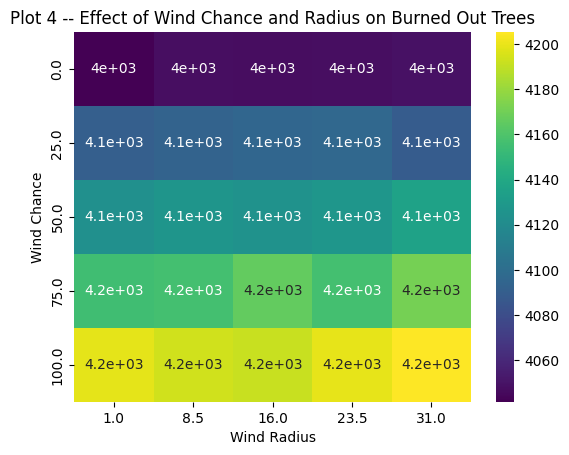

In [10]:
import seaborn as sns

heatmap_data = df.pivot_table(values='Burned Out', index='wind_chance', columns='wind_radius', aggfunc='mean')
sns.heatmap(heatmap_data, cmap='viridis', annot=True)
plt.title('Plot 4 -- Effect of Wind Chance and Radius on Burned Out Trees')
plt.xlabel('Wind Radius')
plt.ylabel('Wind Chance')
plt.show()

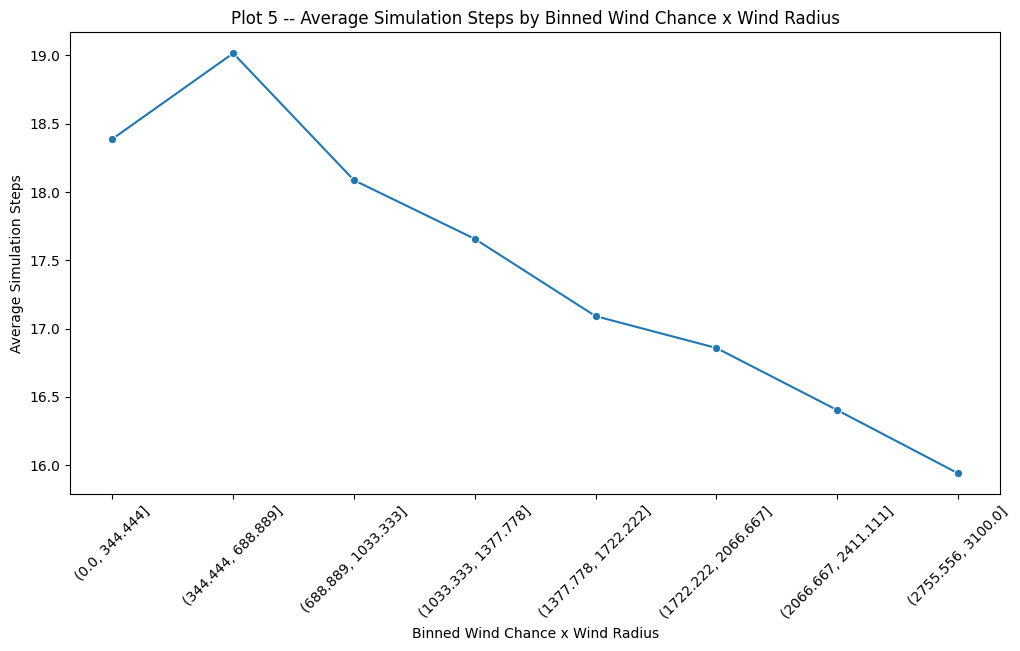

In [35]:
df['Wind Interaction'] = df['wind_chance'] * df['wind_radius']
df['Wind Interaction Bin'] = pd.cut(df['Wind Interaction'], bins=np.linspace(df['Wind Interaction'].min(), df['Wind Interaction'].max(), num=10))

# Calculating the mean and count of steps for each bin
grouped = df.groupby('Wind Interaction Bin', observed=True)['Step'].agg(['mean', 'size']).reset_index()

grouped.rename(columns={'mean': 'Average Steps', 'size': 'Count'}, inplace=True)

# Convert 'Wind Interaction Bin' to string for better plotting
grouped['Wind Interaction Bin'] = grouped['Wind Interaction Bin'].astype(str)

plt.figure(figsize=(12, 6))
sns.lineplot(data=grouped, x='Wind Interaction Bin', y='Average Steps', marker='o')
plt.title('Plot 5 -- Average Simulation Steps by Binned Wind Chance x Wind Radius')
plt.xlabel('Binned Wind Chance x Wind Radius')
plt.ylabel('Average Simulation Steps')
plt.xticks(rotation=45)

plt.show()


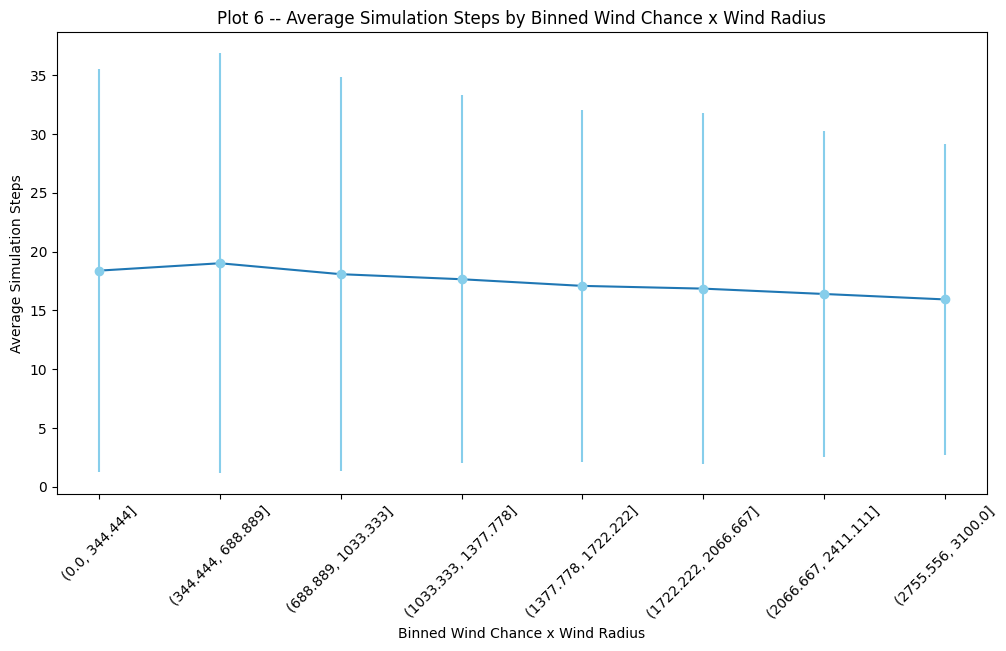

In [37]:
df['Wind Interaction Bin'] = pd.cut(df['Wind Interaction'], bins=np.linspace(df['Wind Interaction'].min(), df['Wind Interaction'].max(), num=10))

# Calculating the mean and standard deviation of steps for each bin
grouped = df.groupby('Wind Interaction Bin', observed=True)['Step'].agg(['mean', 'std', 'size']).reset_index()

grouped.rename(columns={'mean': 'Average Steps', 'std': 'Std Steps', 'size': 'Count'}, inplace=True)

# Convert 'Wind Interaction Bin' to string for better plotting
grouped['Wind Interaction Bin'] = grouped['Wind Interaction Bin'].astype(str)

plt.figure(figsize=(12, 6))
sns.lineplot(data=grouped, x='Wind Interaction Bin', y='Average Steps', marker='o', errorbar='sd')


plt.errorbar(grouped['Wind Interaction Bin'], grouped['Average Steps'], yerr=grouped['Std Steps'], fmt='o', color='skyblue')

plt.title('Plot 6 -- Average Simulation Steps by Binned Wind Chance x Wind Radius')
plt.xlabel('Binned Wind Chance x Wind Radius')
plt.ylabel('Average Simulation Steps')
plt.xticks(rotation=45)

plt.show()



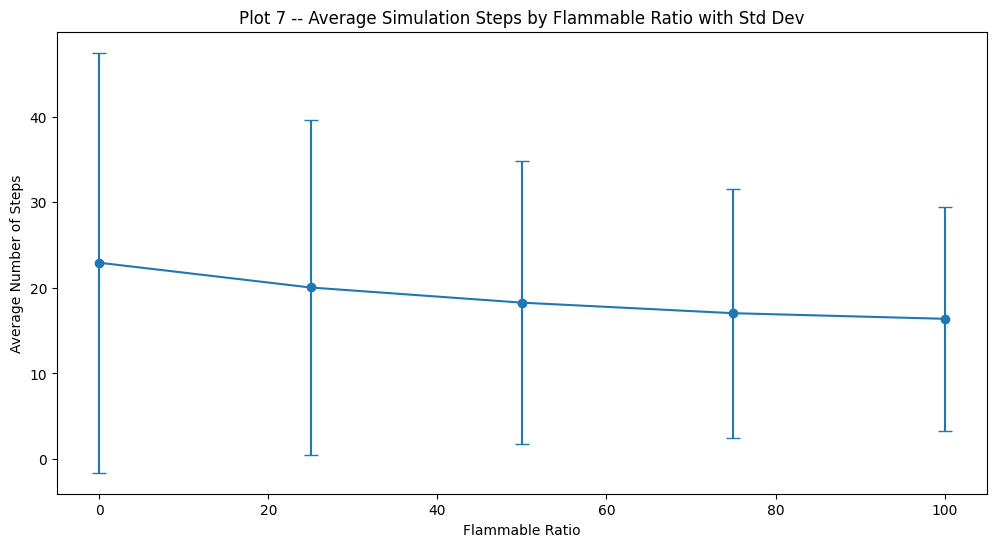

In [16]:

# Calculate mean and standard deviation of steps for each Flammable_ratio
grouped_flammable = df.groupby('Flammable_ratio')['Step'].agg(['mean', 'std']).reset_index()
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.errorbar(grouped_flammable['Flammable_ratio'], grouped_flammable['mean'], yerr=grouped_flammable['std'], fmt='-o', capsize=5)
plt.title('Plot 7 -- Average Simulation Steps by Flammable Ratio with Std Dev')
plt.xlabel('Flammable Ratio')
plt.ylabel('Average Number of Steps')

plt.show()



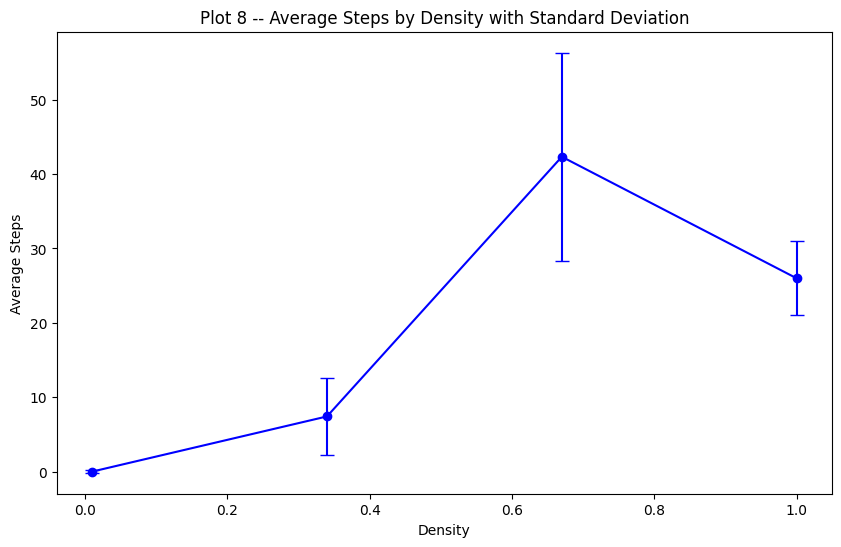

In [38]:

grouped = df.groupby('density')['Step'].agg(['mean', 'std']).reset_index()
grouped.rename(columns={'mean': 'Mean_Steps', 'std': 'Std_Steps'}, inplace=True)


plt.figure(figsize=(10, 6))
plt.errorbar(grouped['density'], grouped['Mean_Steps'], yerr=grouped['Std_Steps'], fmt='-o', ecolor='blue', capsize=5, color='blue')
plt.title('Plot 8 -- Average Steps by Density with Standard Deviation')
plt.xlabel('Density')
plt.ylabel('Average Steps')

plt.show()


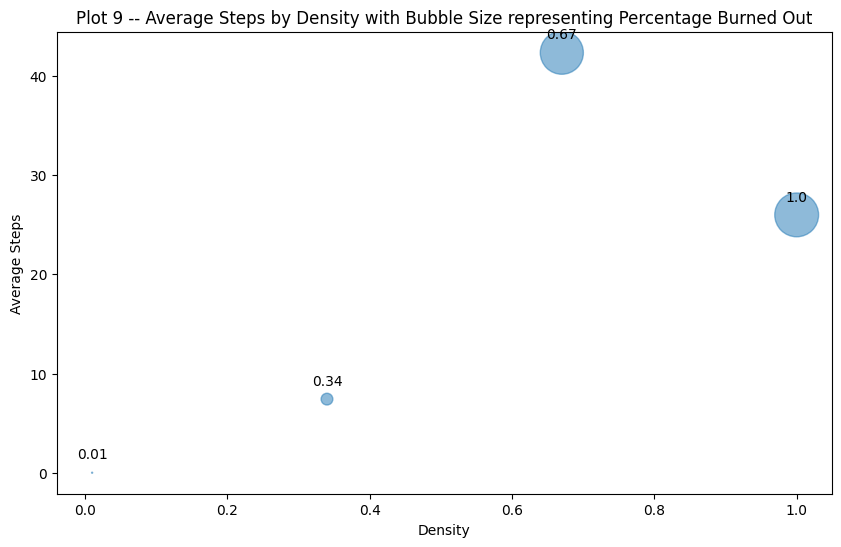

In [20]:

df['Percentage_Burned_Out'] = (df['Burned Out'] / (df['On Fire'] + df['Burned Out']+ df['Fine Flammable']+ df['Fine Resistant'])) * 100

grouped = df.groupby('density').agg({
    'Step': 'mean',
    'Percentage_Burned_Out': 'mean'
}).reset_index()
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))


bubble_sizes = grouped['Percentage_Burned_Out'] * 10  # Adjust the scale factor as needed for better visualization

plt.scatter(grouped['density'], grouped['Step'], s=bubble_sizes, alpha=0.5)

# Annotate each bubble with the density value
for i, txt in enumerate(grouped['density']):
    plt.annotate(txt, (grouped['density'][i], grouped['Step'][i]), textcoords="offset points", xytext=(0,10), ha='center')

plt.title('Plot 9 -- Average Steps by Density with Bubble Size representing Percentage Burned Out')
plt.xlabel('Density')
plt.ylabel('Average Steps')


plt.show()
